<a href="https://colab.research.google.com/github/kristenvonbecker/housing_prediction_random_forest/blob/main/housing_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Price Prediction: Random Forest Regression

This project uses a [Kaggle dataset](https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset/data) (created December 18, 2023) containing U.S. real estate data obtained from [realtor.com](https://www.realtor.com/).
The original dataset contains the following columns:
- `status`: (string) property sale status
- `bed`: (float) number of bedrooms
- `bath`: (float) number of bathrooms
- `acre_lot`: (float) total land size, in acres
- `city`: (string) city
- `state`: (string) state
- `zip_code`: (float) zip code
- `house_size`: (float) total living area, in square feet
- `prev_sold_date`: (string) date property was sold
- `price`: (float) property price, in USD

The goal is to build a random forest model which will predict `price` as a function of the remaining features. This involves the following steps:

1. Perform thorough EDA to thoroughly understand the dataset
 - Get summary statistics
 - Remove any duplicate data
 - Reformat features, if necessary
 - Investigate feature distributions
 - Identify missing data
 - Determine outliers
 - Identify correlation
2. Split the data into train and test sets to prevent data leakage
3. Scrub the data (handling missing values and outliers)
 - Handle outliers
 - Handle missing values
4. Engineer the features to use in the model
 - Transform numerical features
 - Encode categorical features
 - Feature extraction pipeline
5. Design the random forest model
 - Instantiate `RandomForestRegressor()` model
 - Hyperparameter tuning
6. Train, test, and evaluate the model
7. Comment on the results and generalizability of the model

## Dependencies


Import necessary Python libraries and modules:

In [1]:
!pip install pgeocode

In [2]:
# for import/export in Colab
from google.colab import files
import io

# for handling data
import pandas as pd
import numpy as np
import datetime
from scipy import stats
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, QuantileTransformer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
import pgeocode
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
# from pandas.tools.plotting import plot_frame

# for visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import seaborn as sns

# for prediction
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Import data from CSV file and save to dataframe `df`:

In [3]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['realtor-data.csv']))

Saving realtor-data.csv to realtor-data.csv


## Data analysis

### Data types and values

Print a random saple of the dataframe:

In [4]:
df.sample(frac=1, random_state=14).head(10)

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
850271,for_sale,3.0,2.0,NaN,New York City,New York,10065.0,NaN,NaN,3150000.0
563143,for_sale,3.0,1.0,NaN,New York,New York,10031.0,NaN,2017-04-27,179000.0
1298456,for_sale,6.0,4.0,0.33,Greenwich,New York,12834.0,4776.0,2020-03-13,649500.0
1275917,for_sale,NaN,NaN,2.41,Hopewell Junction,New York,12533.0,NaN,NaN,184500.0
990579,for_sale,2.0,4.0,NaN,Woodland Park,New Jersey,7424.0,NaN,NaN,499900.0
344095,for_sale,NaN,NaN,10.91,West Windsor,Vermont,5037.0,NaN,NaN,184900.0
290231,for_sale,2.0,3.0,19.00,Effingham,New Hampshire,3882.0,2890.0,NaN,599000.0
607782,for_sale,5.0,5.0,0.50,Montclair,New Jersey,7042.0,NaN,1997-01-23,1249000.0
1400400,for_sale,3.0,2.0,0.29,Hamburg,New York,14075.0,1530.0,1999-03-05,150000.0
1346608,for_sale,2.0,2.0,0.38,Cazenovia,New York,13035.0,1842.0,NaN,380000.0


Get dataframe info:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401066 entries, 0 to 1401065
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   status          1401066 non-null  object 
 1   bed             1184538 non-null  float64
 2   bath            1206853 non-null  float64
 3   acre_lot        1043599 non-null  float64
 4   city            1400875 non-null  object 
 5   state           1401066 non-null  object 
 6   zip_code        1400587 non-null  float64
 7   house_size      950954 non-null   float64
 8   prev_sold_date  714773 non-null   object 
 9   price           1400958 non-null  float64
dtypes: float64(6), object(4)
memory usage: 106.9+ MB


Define data labels and units (for use in graphics):

In [ ]:
labels = {
    'status': 'Property Sale Status',
    'bed': 'Number of Bedrooms',
    'bath': 'Number of Bathrooms',
    'acre_lot': 'Total Land Size',
    'city': 'City',
    'state': 'State',
    'zip_code': 'Zip Code',
    'house_size': 'Total Living Space',
    'prev_sold_date': 'Date of Previous Sale',
    'price': 'Total Property Price'
}

units = {
    'bed': '# of Bedrooms',
    'bath': '# of Bathrooms',
    'acre_lot': 'Lot Size (Acre)',
    'house_size': 'House Size (1K Sq Ft)',
    'price': 'Price ($1M USD)',
    'log_bed': 'Log(# of Bedrooms)',
    'log_bath': 'Log(# of Bathrooms)',
    'log_acre_lot': 'Log(Lot Size)',
    'log_house_size': 'Log(House Size)',
    'log_price': 'Log(Price)',
}

### Duplicate data

Count number of duplicate observations in dataframe:

In [6]:
num_duplicates = df.duplicated().sum()
print("{} duplicate observations".format(num_duplicates))

1249026 duplicate observations


Drop duplicate observations:

In [4]:
df.drop_duplicates(ignore_index=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152040 entries, 0 to 152039
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          152040 non-null  object 
 1   bed             126791 non-null  float64
 2   bath            128499 non-null  float64
 3   acre_lot        115074 non-null  float64
 4   city            152004 non-null  object 
 5   state           152040 non-null  object 
 6   zip_code        151993 non-null  float64
 7   house_size      102571 non-null  float64
 8   prev_sold_date  79419 non-null   object 
 9   price           152020 non-null  float64
dtypes: float64(6), object(4)
memory usage: 11.6+ MB


### Data formatting

Convert `zip_code` into `latitude` and `longitude` features:

In [5]:
us = pgeocode.Nominatim('us')
pr = pgeocode.Nominatim('pr')
vi = pgeocode.Nominatim('vi')

def format(zip_code):
  digits = len(zip_code)
  if 1 < digits < 5:
    leading_zeros = "0" * (5 - digits)
    zip_code = leading_zeros + zip_code
  return zip_code

def get_location(zip_code):
  digits = len(zip_code)
  if 1 < digits < 5:
    leading_zeros = "0" * (5 - digits)
    zip_code = leading_zeros + zip_code
  if zip_code.startswith('00'):
    location = vi.query_postal_code(zip_code)
    if location.place_name is None:
      location = pr.query_postal_code(zip_code)
  else:
    location = us.query_postal_code(zip_code)
  return location.latitude, location.longitude

df['zip_code'] = df['zip_code'].fillna(0).astype(int).astype(str).apply(lambda x: format(x))
unique_zip_codes = df['zip_code'].unique().tolist()

zip_code_location = {x: get_location(x) for x in unique_zip_codes}
zip_code_data = {
    'zip_code': list(zip_code_location.keys()),
    'latitude': [lat for lat, lon in list(zip_code_location.values())],
    'longitude': [lon for lat, lon in list(zip_code_location.values())]
}
zip_code_df = pd.DataFrame(data=zip_code_data)
df = df.reset_index().merge(zip_code_df, on='zip_code', how='left').set_index('index').drop(columns='zip_code')

Reformat `prev_sold_date` as a datetime value:

In [6]:
df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'])

Confirm updates:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152040 entries, 0 to 152039
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   status          152040 non-null  object        
 1   bed             126791 non-null  float64       
 2   bath            128499 non-null  float64       
 3   acre_lot        115074 non-null  float64       
 4   city            152004 non-null  object        
 5   state           152040 non-null  object        
 6   house_size      102571 non-null  float64       
 7   prev_sold_date  79419 non-null   datetime64[ns]
 8   price           152020 non-null  float64       
 9   latitude        149322 non-null  float64       
 10  longitude       149322 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 13.9+ MB


In [11]:
df.sample(frac=1, random_state=14).head(10)

,status,bed,bath,acre_lot,city,state,house_size,prev_sold_date,price,latitude,longitude
index,,,,,,,,,,,
47799,for_sale,3.0,4.0,NaN,New York,New York,2109.0,NaT,4380000.0,40.7313,-73.9892
85328,for_sale,NaN,NaN,43.33,Jackson,New Jersey,NaN,NaT,475000.0,40.1210,-74.3017
64122,for_sale,5.0,3.0,0.17,Howard Beach,New York,2871.0,NaT,1050000.0,40.6588,-73.8438
9545,for_sale,3.0,2.0,0.17,New Britain,Connecticut,1014.0,2010-08-03,225000.0,41.6867,-72.7908
7892,for_sale,2.0,1.0,0.63,West Stockbridge,Massachusetts,720.0,2006-08-10,285000.0,42.3348,-73.3825
149523,for_sale,7.0,3.0,0.15,Buffalo,New York,3430.0,NaT,100000.0,42.9082,-78.8225
142483,for_sale,3.0,2.0,2.50,Cortland,New York,1436.0,2013-05-16,219900.0,42.5952,-76.1857
89438,for_sale,2.0,2.0,0.04,Primos,Pennsylvania,684.0,2006-04-28,150000.0,39.9218,-75.2876
142165,for_sale,3.0,1.0,20.37,Waterloo,New York,924.0,NaT,64900.0,42.9045,-76.8755


### Summary statistics



Get summary stats for numerical features (`bed`, `bath`, `acre_lot`, `house_size`, `latitude`, `longitude`) and target variable (`price`):

In [12]:
df.describe().applymap(lambda x: f"{x:0.1f}")

,bed,bath,acre_lot,house_size,price,latitude,longitude
count,126791.0,128499.0,115074.0,102571.0,152020.0,149322.0,149322.0
mean,3.4,2.5,26.4,2164.1,858281.2,41.3,-73.7
std,1.9,1.7,1126.9,5296.2,3097909.2,2.1,1.7
min,1.0,1.0,0.0,4.0,0.0,17.7,-121.4
25%,2.0,2.0,0.1,1176.0,225000.0,40.6,-74.5
50%,3.0,2.0,0.3,1688.0,425000.0,40.9,-74.0
75%,4.0,3.0,1.2,2496.0,785000.0,42.1,-73.2
max,123.0,198.0,100000.0,1450112.0,875000000.0,47.3,-64.7


Get summary stats for datetime feature (`prev_sold_date`):

In [13]:
df.describe(include='datetime64[ns]', datetime_is_numeric=True)

,prev_sold_date
count,79419
mean,2009-09-20 09:49:25.481811456
min,1901-01-01 00:00:00
25%,2003-09-22 00:00:00
50%,2011-08-19 00:00:00
75%,2018-03-09 00:00:00
max,2023-03-01 00:00:00


Get summary statistics for categorical features (`status`, `city`, `state`):

In [14]:
df.describe(include='object')

,status,city,state
count,152040,152004,152040
unique,2,3512,19
top,for_sale,New York City,New York
freq,151745,8162,67159


##### NOTES

- The features `acre_lot`, `house_size`, and the target variable `price` have some very high outliers and are each **skewed** in the positive direction.
- The feature `prev_sold_date` has some low outliers.
- The categorical feature `status` is binary and observations in its majority class account for the vast majority of the data.

### Missing data

Get frequency and percentage of missing data for each variable:

In [ ]:
num_missing = df.isna().sum()
print("# of data missing by variable:")
num_missing

# of data missing by variable:


status                0
bed               25249
bath              23541
acre_lot          36966
city                 36
state                 0
house_size        49469
prev_sold_date    72621
price                20
latitude           2718
longitude          2718
dtype: int64

In [ ]:
perc_missing = (df.isna().sum() * 100 / len(df)).round(decimals=2)
print("% of data missing by variable:")
perc_missing

% of data missing by variable:


status             0.00
bed               16.61
bath              15.48
acre_lot          24.31
city               0.02
state              0.00
house_size        32.54
prev_sold_date    47.76
price              0.01
latitude           1.79
longitude          1.79
dtype: float64

Add column to dataframe indicating the observation's number of missing values:

In [7]:
columns = df.drop(['price', 'longitude'], axis=1).columns

missing = df[columns].isnull()
df['num_missing'] = missing.sum(axis=1)
df.head()

,status,bed,bath,acre_lot,city,state,house_size,prev_sold_date,price,latitude,longitude,num_missing
index,,,,,,,,,,,,
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,920.0,NaT,105000.0,NaN,NaN,2
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,1527.0,NaT,80000.0,NaN,NaN,2
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,748.0,NaT,67000.0,NaN,NaN,2
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,1800.0,NaT,145000.0,NaN,NaN,2
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,NaN,NaT,65000.0,NaN,NaN,3


### Data distributions

Distribution of `price` on log scale:

array([[<Axes: title={'center': 'log_price'}>]], dtype=object)

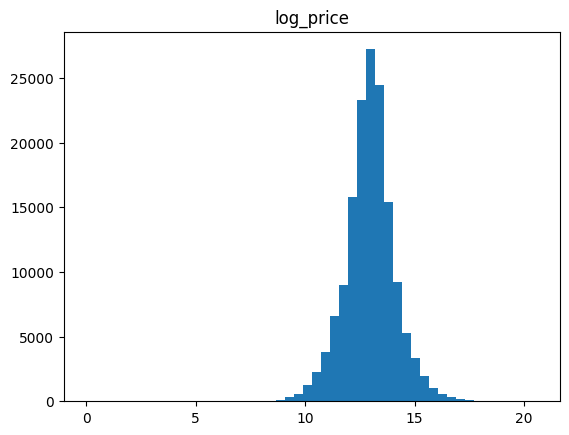

In [85]:
df_temp = df.copy()
df_temp['log_price'] = df_temp['price'].map(lambda x: np.log1p(x))
df_temp.hist(column='log_price', bins=50, grid=False)

Boxplots of numerical features:

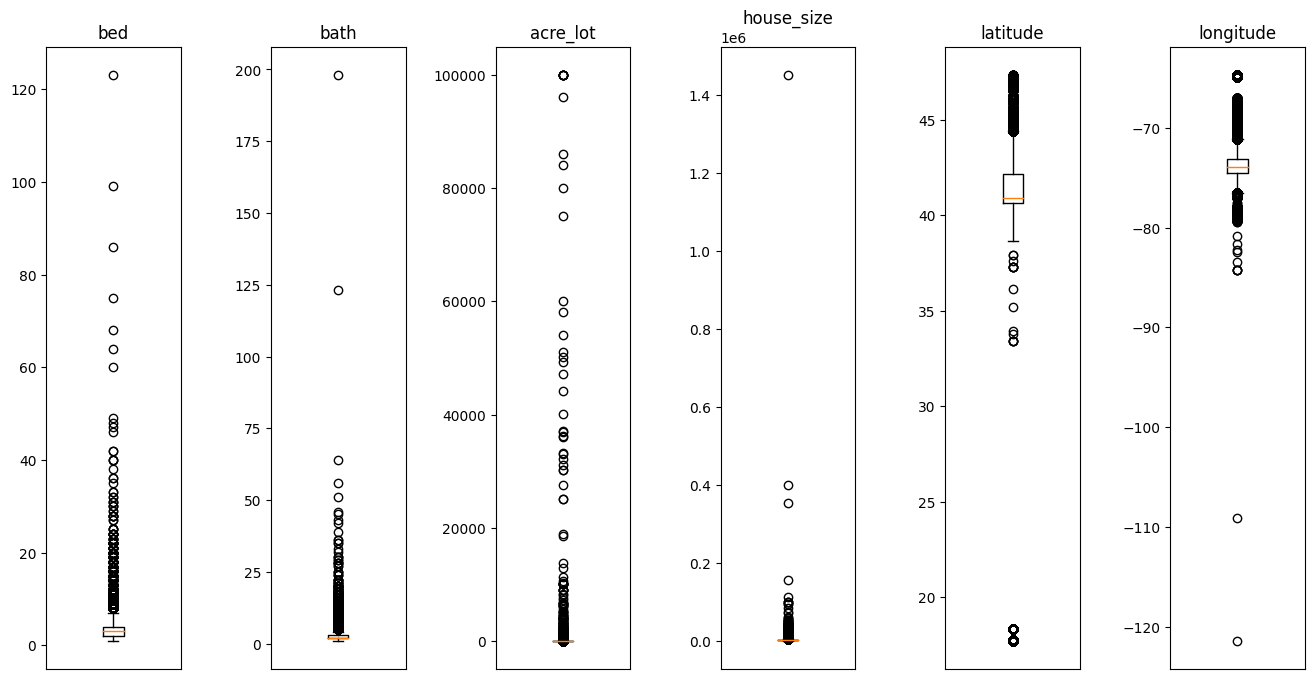

In [12]:
num_variables = ['bed', 'bath', 'acre_lot', 'house_size', 'latitude', 'longitude']

fig = plt.figure(figsize=(18, 7))

for i, var in enumerate(num_variables):
  ax = fig.add_subplot(1, 8, i+1)
  ax.boxplot(df[var][~df[var].isna()], meanline=True)
  plt.title(var)
  plt.tick_params(axis='x', bottom=False, labelbottom=False)

fig.tight_layout(pad=2.0)
plt.show()

Boxplots of numerical features (except for latitude and longitude) and target variable on log scale:

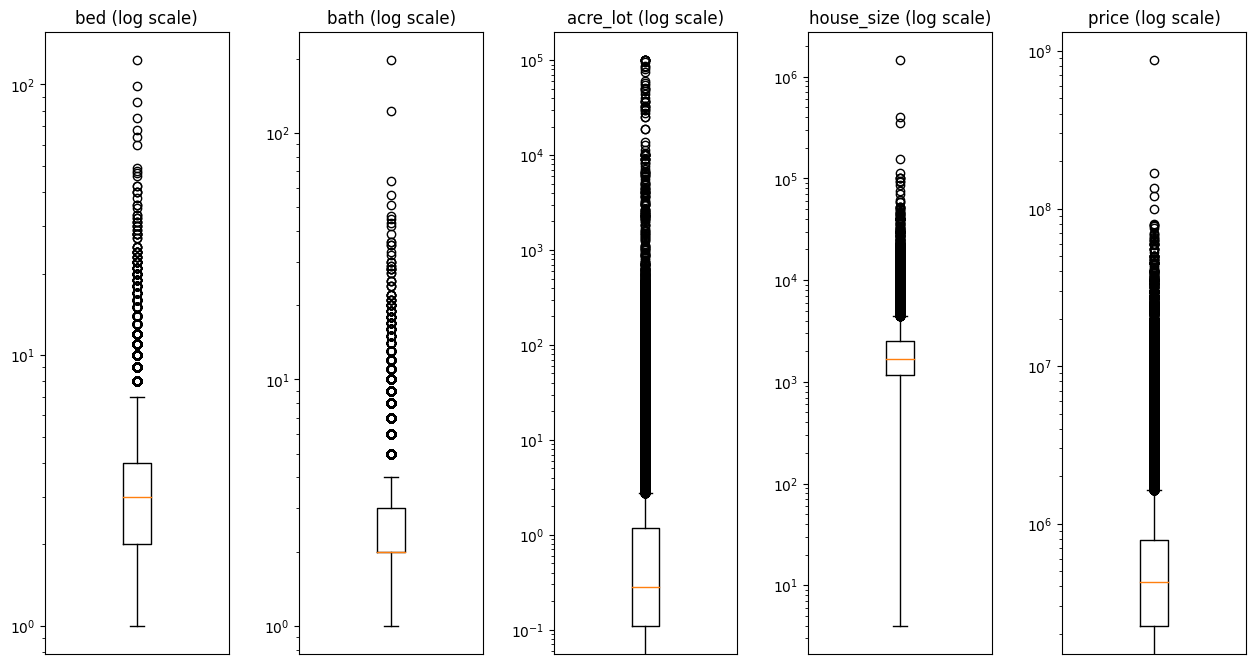

In [16]:
# change these to histograms

log_num_variables = [var for var in num_variables if var not in ['latitude', 'longitude']]

fig = plt.figure(figsize=(18, 7))

for i, var in enumerate(log_num_variables):
  ax = fig.add_subplot(1, 7, i+1)
  ax.boxplot(df[var][~df[var].isna()], meanline=True)
  ax.set_yscale('log')
  plt.title("{} (log scale)".format(var))
  plt.tick_params(axis='x', bottom=False, labelbottom=False)

fig.tight_layout(pad=2.0)
plt.show()

Scatterplot of `latitude` vs. `longitude`:

<ipython-input-17-6923e4668377>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


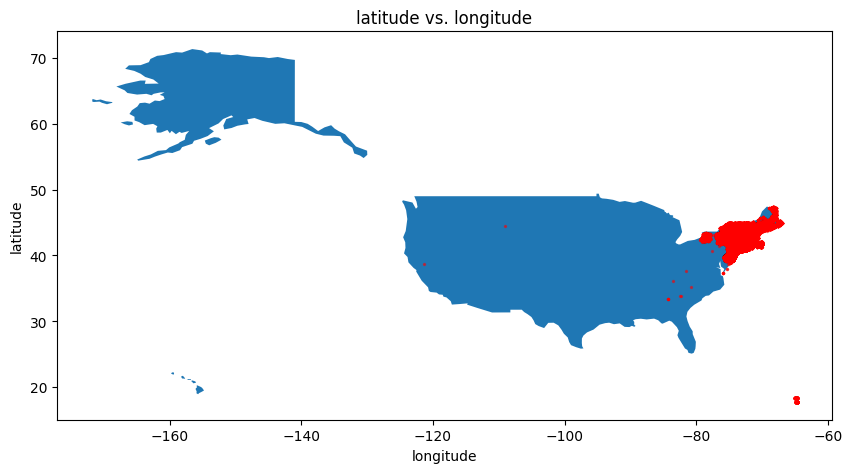

In [17]:
# figure out how to isolate a given lat-long rectangle in the map

geometry = [Point(x, y) for (x, y) in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
united_states = north_america[north_america.name == 'United States of America']

gdf.plot(ax=united_states.plot(figsize=(10, 6)), color='red', markersize=2, alpha=0.5);
plt.title("latitude vs. longitude")
plt.xlabel("longitude")
plt.ylabel("latitude")

plt.show()

Distribution of `prev_sold_date`:

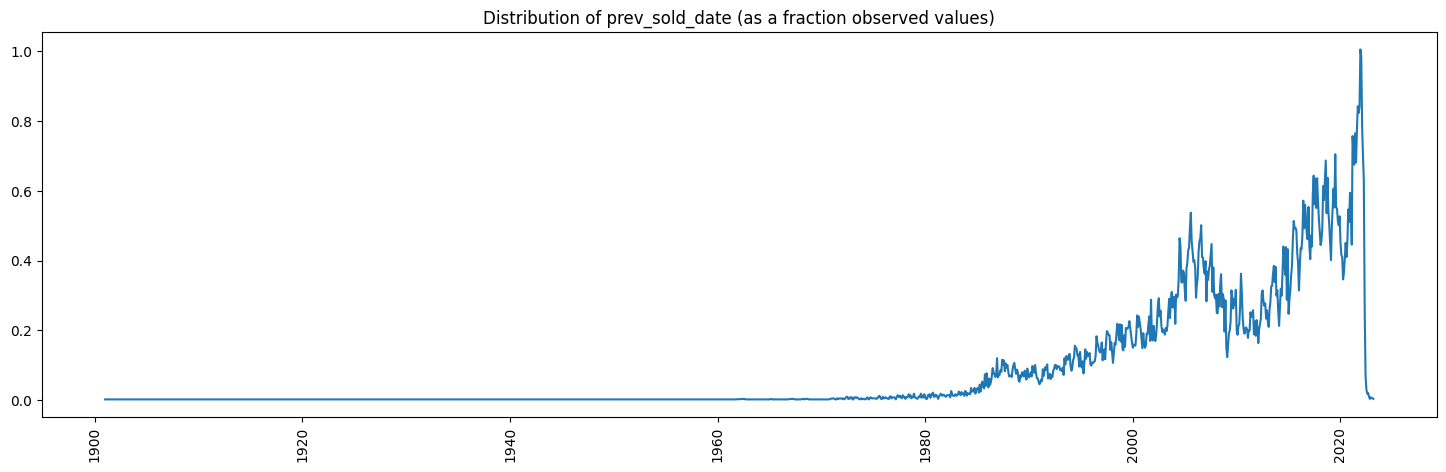

In [179]:
# statify by number of missing values

date_df = df['prev_sold_date'][~df['prev_sold_date'].isnull()].to_frame()
date_df['year'] = date_df['prev_sold_date'].map(lambda x: x.year)
date_df['month'] = date_df['prev_sold_date'].map(lambda x: x.month)

date_counts = date_df.drop('prev_sold_date', axis=1).groupby(['year', 'month']).value_counts().to_frame()
date_counts.reset_index(level=['year', 'month'], inplace=True)
date_counts.columns = ['year', 'month', 'count']

date_counts['date'] = date_counts.apply(lambda x: pd.to_datetime('{}-{}'.format(x.month, x.year), format="%m-%Y"), axis=1)
date_counts['date'] = date_counts['date'].apply(lambda x: pd.to_datetime(x, format='%m-%Y'))

date_counts.drop(columns=['year', 'month'], inplace=True)

date_counts['perc'] = date_counts['count'].apply(lambda x: x / (~date_counts['count'].isnull()).sum())

fig = plt.figure(figsize=(18, 5))
plt.plot(date_counts['date'], date_counts['perc'])
plt.xticks(rotation='vertical')
plt.title('Distribution of prev_sold_date (as a fraction observed values)')

plt.show()

Distribution of `status`:

In [18]:
status_counts = df['status'].value_counts()
status_counts

for_sale          151745
ready_to_build       295
Name: status, dtype: int64

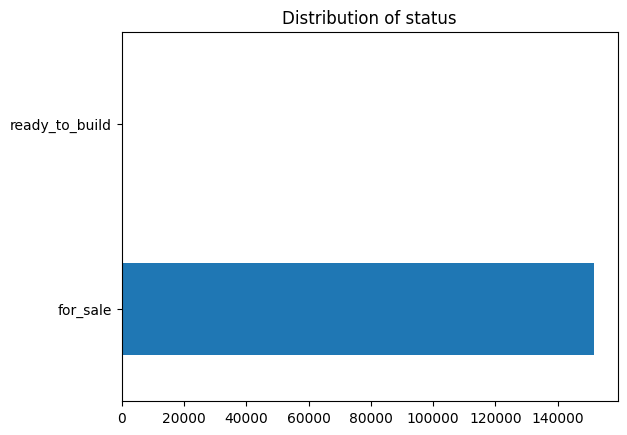

In [19]:
status_counts.plot(kind='barh', title='Distribution of status');

Distribution of `state`:

In [20]:
state_counts = df['state'].value_counts()
state_counts

New York          67159
New Jersey        32601
Connecticut       13753
Massachusetts     10051
Pennsylvania       9549
Maine              4938
New Hampshire      3431
Rhode Island       3332
Puerto Rico        2645
Vermont            2544
Delaware           1290
Virgin Islands      730
Virginia              7
Georgia               5
West Virginia         1
Tennessee             1
Wyoming               1
South Carolina        1
Louisiana             1
Name: state, dtype: int64

<Axes: title={'center': 'Distribution of state: Cululative proportions'}>

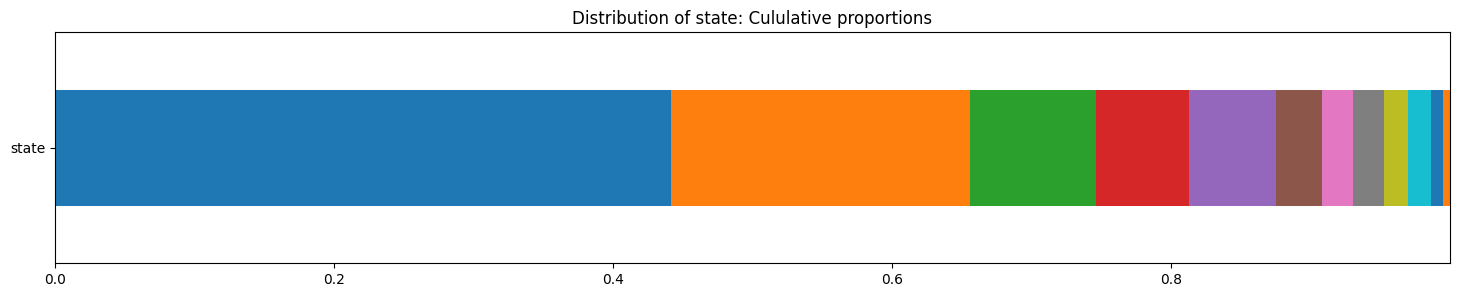

In [216]:
# stratefy by number of missing values

state_perc = df['state'].value_counts(normalize=True).to_frame()
state_perc.T.plot.barh(stacked=True, title='Distribution of state: Cululative proportions', figsize=(18,3), legend=False)

Distribution of `city`:



In [215]:
city_counts = df['city'].value_counts()
city_counts.head(20)

New York City    8162
Philadelphia     5425
New York         5185
Brooklyn         4800
Bronx            1603
Staten Island    1581
Boston           1242
Buffalo           844
Flushing          787
Toms River        739
Newark            737
Manhattan         720
Syracuse          699
Wilmington        674
Middletown        655
Jersey City       627
Jamaica           612
Queens            505
Stamford          499
Bridgeport        484
Name: city, dtype: int64

<Axes: title={'center': 'Unlabeled distribution of city: Cululative proportions'}>

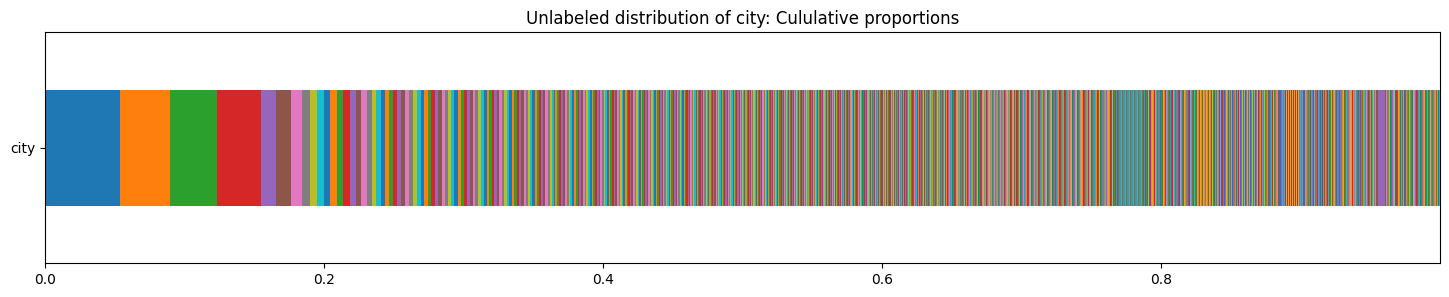

In [177]:
city_perc = df['city'].value_counts(normalize=True).to_frame()
city_perc.T.plot.barh(stacked=True, figsize=(18,3), title='Unlabeled distribution of city: Cululative proportions', legend=False)

##### NOTES

- All of the numerical features except for `latitude` and `longitude` are more normally (at least symmetrically) distributed on a log scale.
- The high outliers in `bed`, `bath`, and `house_size` could represent multi-family housing properties.
- The features `latitude` and `longitude` are fairly symmetric, each with a few low outliers representing properties located outside of the U.S. Northeast.
- The feature `prev_sold_date` has a very skewed (toward the past) distribution, as well as many low outliers.
- The target variable `price` has some very high outliers, but these could correllate with multi-family housing.
- The feature `status` is too imbalanced to use for prediction.
- The feature `state` is dominated by about half of its values; these represent a subset of the U.S. Northeast.
- The feature `city` takes on *many* values -- too many to be useful.




### Outliers

Investigate presence of outliers among (log transformed) numerical features:



In [8]:
# define a function to use in the pipeline?

log_num_features = ['bed', 'bath', 'acre_lot', 'house_size']
num_features = ['bed', 'bath', 'acre_lot', 'house_size', 'latitude', 'longitude']

z_threshold = 3
outlier_thresholds = dict.fromkeys(num_features, (np.nan, np.nan))

for feature in num_features:

  if feature in log_num_features:
    data = np.log1p(df[feature])
  else:
    data = df[feature]

  z_scores = stats.zscore(data, nan_policy='omit')

  num_low = (z_scores < -1 * z_threshold).sum()
  perc_low = num_low / len(df[~df[feature].isna()])

  num_high = (z_scores > z_threshold).sum()
  perc_high = num_high / len(df[~df[feature].isna()])

  low_threshold = data.mean() - z_threshold * data.std()
  high_threshold = data.mean() + z_threshold * data.std()

  outlier_thresholds[feature] = (low_threshold, high_threshold)

  log_scale = " (log transformed)" if feature in log_num_features else ""
  print("{}{}:\n{} ({:.2%}) low outliers, {} ({:.2%}) high outliers".format(feature, log_scale, num_low, perc_low, num_high, perc_high))
  print("low threshold: {:.2}, high threshold: {:.2}\n".format(low_threshold, high_threshold))

bed (log transformed):
0 (0.00%) low outliers, 594 (0.47%) high outliers
low threshold: 0.32, high threshold: 2.5

bath (log transformed):
0 (0.00%) low outliers, 1007 (0.78%) high outliers
low threshold: 0.072, high threshold: 2.3

acre_lot (log transformed):
0 (0.00%) low outliers, 3207 (2.79%) high outliers
low threshold: -2.3, high threshold: 3.7

house_size (log transformed):
71 (0.07%) low outliers, 695 (0.68%) high outliers
low threshold: 5.7, high threshold: 9.2

latitude:
721 (0.48%) low outliers, 0 (0.00%) high outliers
low threshold: 3.5e+01, high threshold: 4.7e+01

longitude:
184 (0.12%) low outliers, 1803 (1.21%) high outliers
low threshold: -7.9e+01, high threshold: -6.9e+01



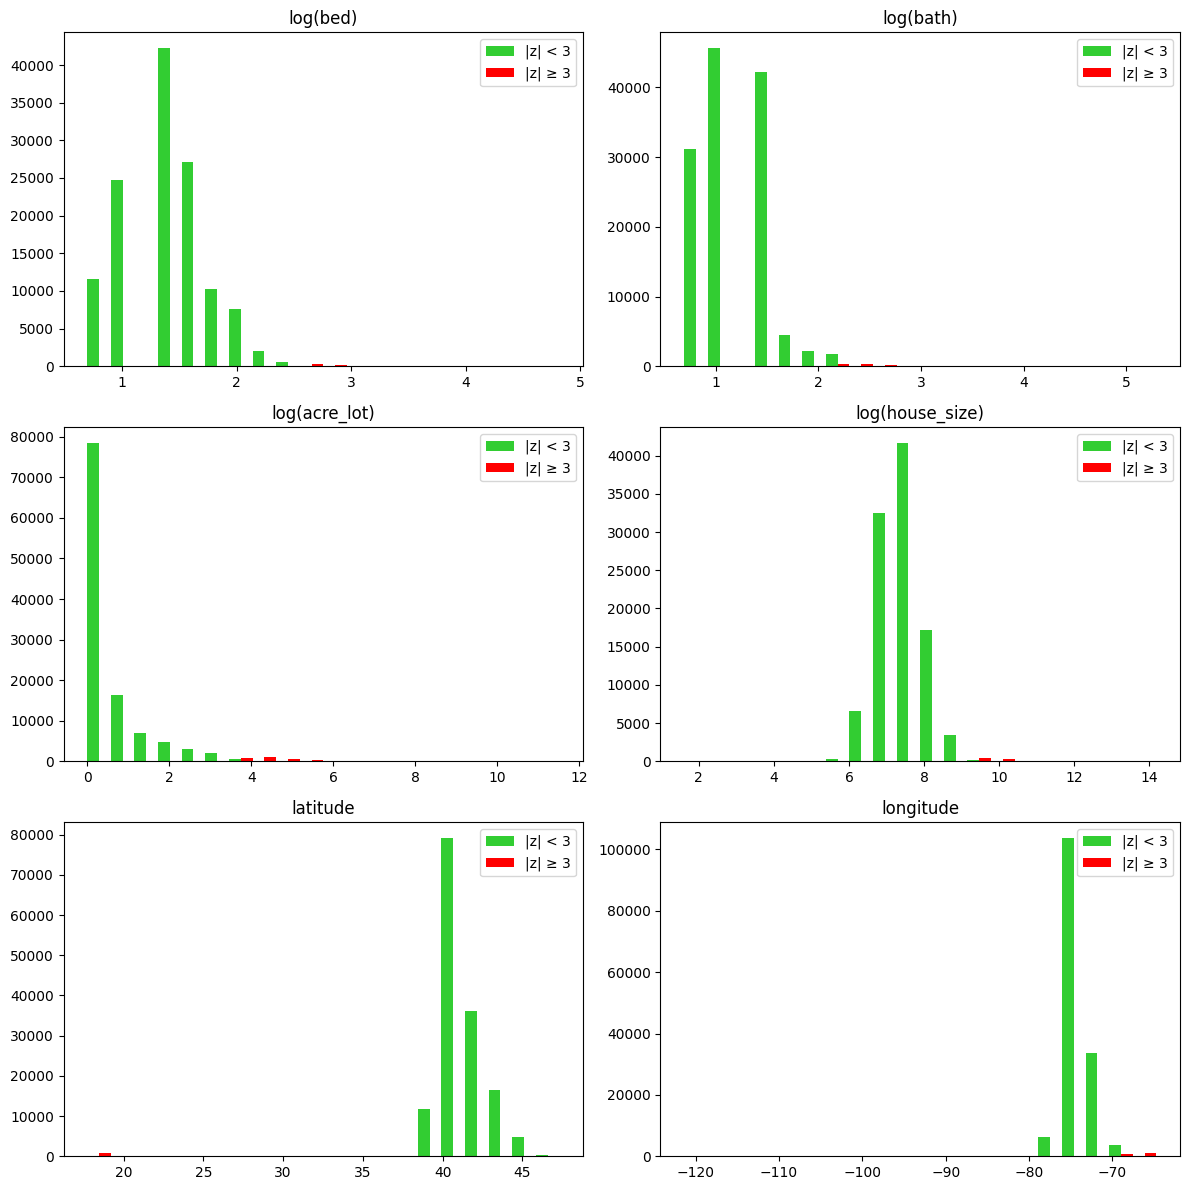

In [84]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()

df_temp = df.copy()
df_temp[log_num_features] = np.log1p(df_temp[log_num_features])

label = ['|z| < 3', '|z| ≥ 3']

for i, var in enumerate(num_features):

  df_temp['outlier'] = (df_temp[var].map(lambda x: (x < outlier_thresholds[var][0]) | (x > outlier_thresholds[var][1])))

  axs[i].hist(x=[df_temp[var][~df_temp['outlier']], df_temp[var][df_temp['outlier']]], color=['limegreen', 'red'], bins=20, rwidth=1, label=label)
  axs[i].legend()

  if var in log_num_features:
    axs[i].set_title("log({})".format(var))
  else:
    axs[i].set_title(var)

plt.tight_layout()
plt.show()

In [ ]:
# outliers in price

### Correlation

Investigate linear correlation between numerical variables:

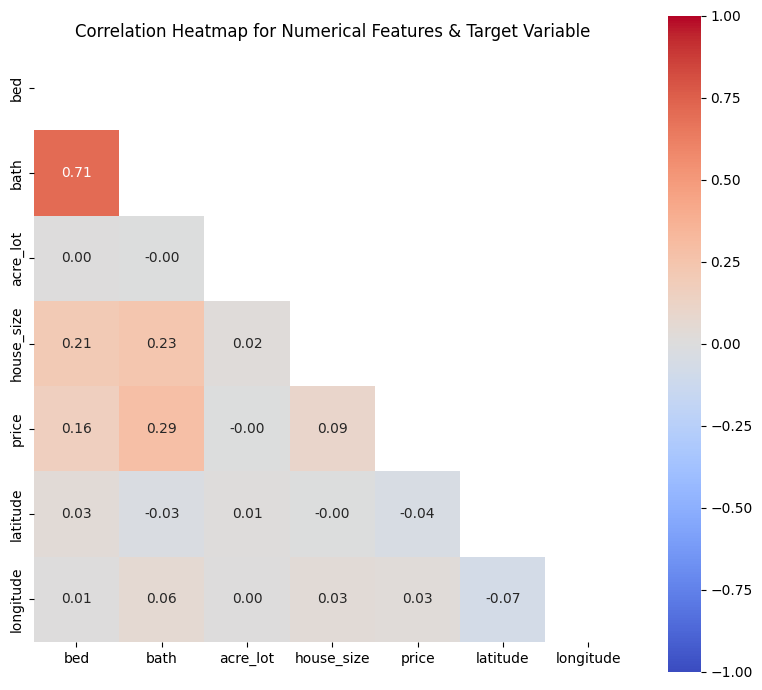

In [74]:
def force_aspect(ax,aspect=1):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1 - x0) / abs(y1 - y0) / aspect)

fig, ax = plt.subplots(figsize=(8,7))

mask = np.triu(np.ones_like(df.corr(numeric_only=True)))
heatmap = sns.heatmap(df.corr(numeric_only=True), mask=mask, robust=True, vmin=-1, vmax=1, annot=True, fmt="1.2f", cmap="coolwarm")
plt.title("Correlation Heatmap for Numerical Features & Target Variable")

force_aspect(ax)

plt.tight_layout()
plt.show()

In [ ]:
# correlation after removing outliers

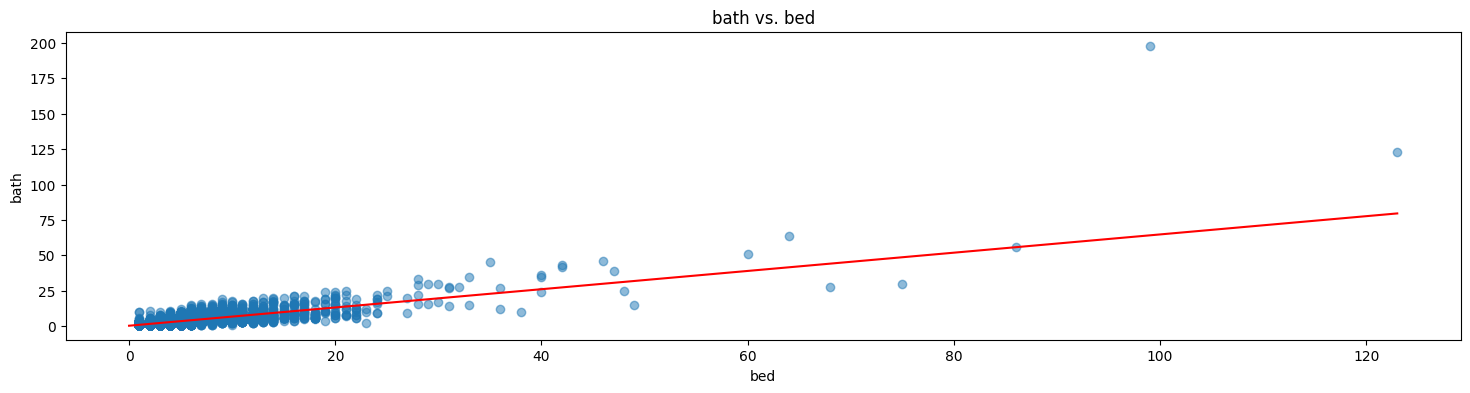

In [76]:
# add color indicator for outliers

fig = plt.figure(figsize=(18, 4))
ax = plt.gca()
plt.scatter(df['bed'], df['bath'], alpha=0.5)

neither_null = ~(df['bed'].isnull() | df['bath'].isnull())
reg = stats.linregress(x=df['bed'][neither_null], y=df['bath'][neither_null])

x_range = np.linspace(0, 123, 10).tolist()
y_range = [reg.slope * x + reg.intercept for x in x_range]
plt.plot(x_range, y_range, 'r')

plt.title('bath vs. bed')
plt.xlabel('bed')
plt.ylabel('bath')

plt.show()

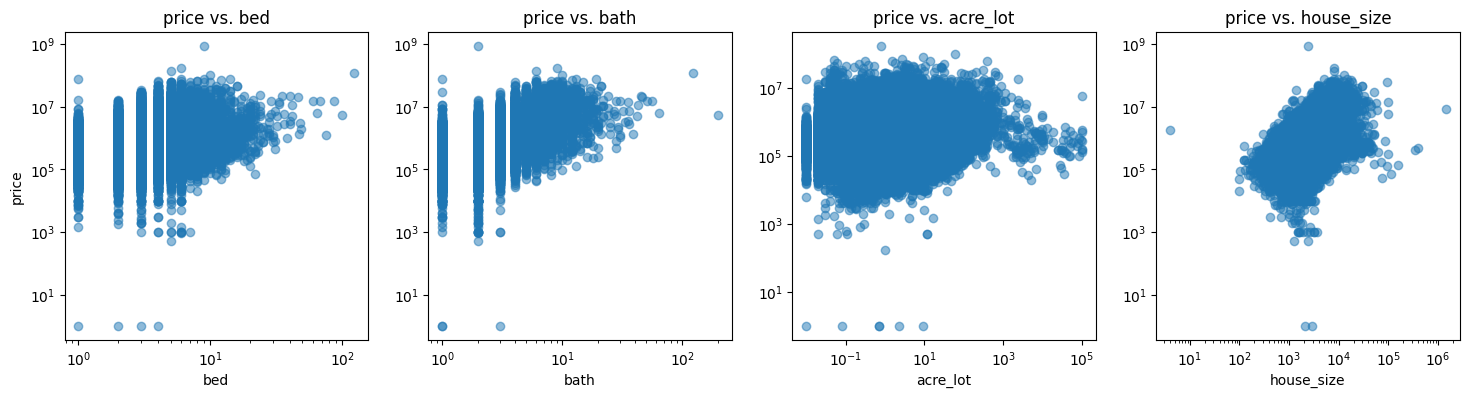

In [77]:
# add color indicator for outliers

fig = plt.figure(figsize=(18, 4))

features = ['bed', 'bath', 'acre_lot', 'house_size']

for i, feature in enumerate(features):
  fig.add_subplot(1, 4, i+1)
  ax = plt.gca()
  plt.scatter(df[feature], df['price'], alpha=0.5)
  ax.set_xscale('log')
  ax.set_yscale('log')
  plt.title('price vs. {}'.format(feature))
  plt.xlabel("{}".format(feature))
  if i == 0:
    plt.ylabel('price')

plt.show()

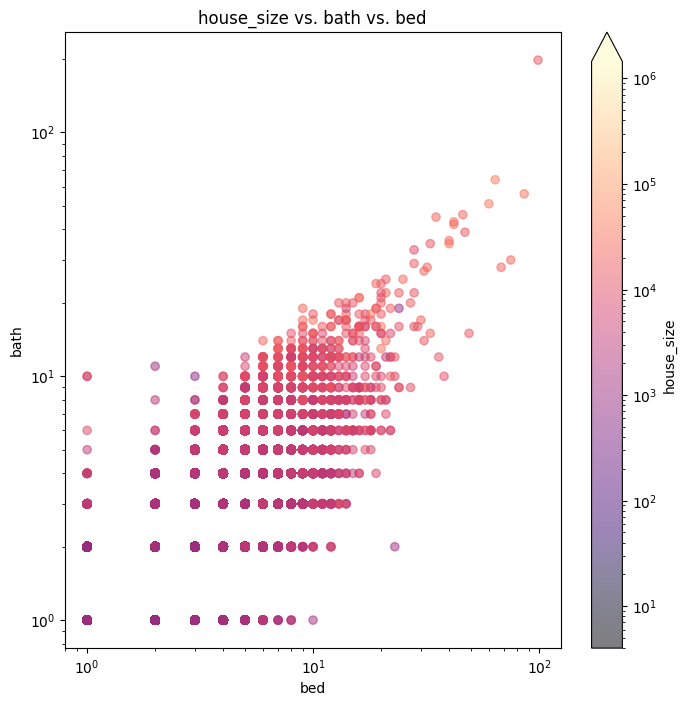

In [182]:
cm = plt.colormaps.get_cmap('magma')
vmin = df['house_size'].min()
vmax = df['house_size'].max()

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()

plot = plt.scatter(df['bed'], df['bath'], alpha=0.5, c=df['house_size'], cmap=cm, norm=colors.LogNorm(vmin=vmin, vmax=vmax))

plt.title('house_size vs. bath vs. bed')
plt.xlabel('bed')
plt.ylabel('bath')
ax.set_xscale('log')
ax.set_yscale('log')

color_ticks = [vmax * t + vmin * (1 - t) for t in np.linspace(vmin, vmax, 5)]
plt.colorbar(plot, label="house_size", extend='max', alpha=1)

plt.show()

# this plot is not informative

Investigate the `price` of observations with missing data.

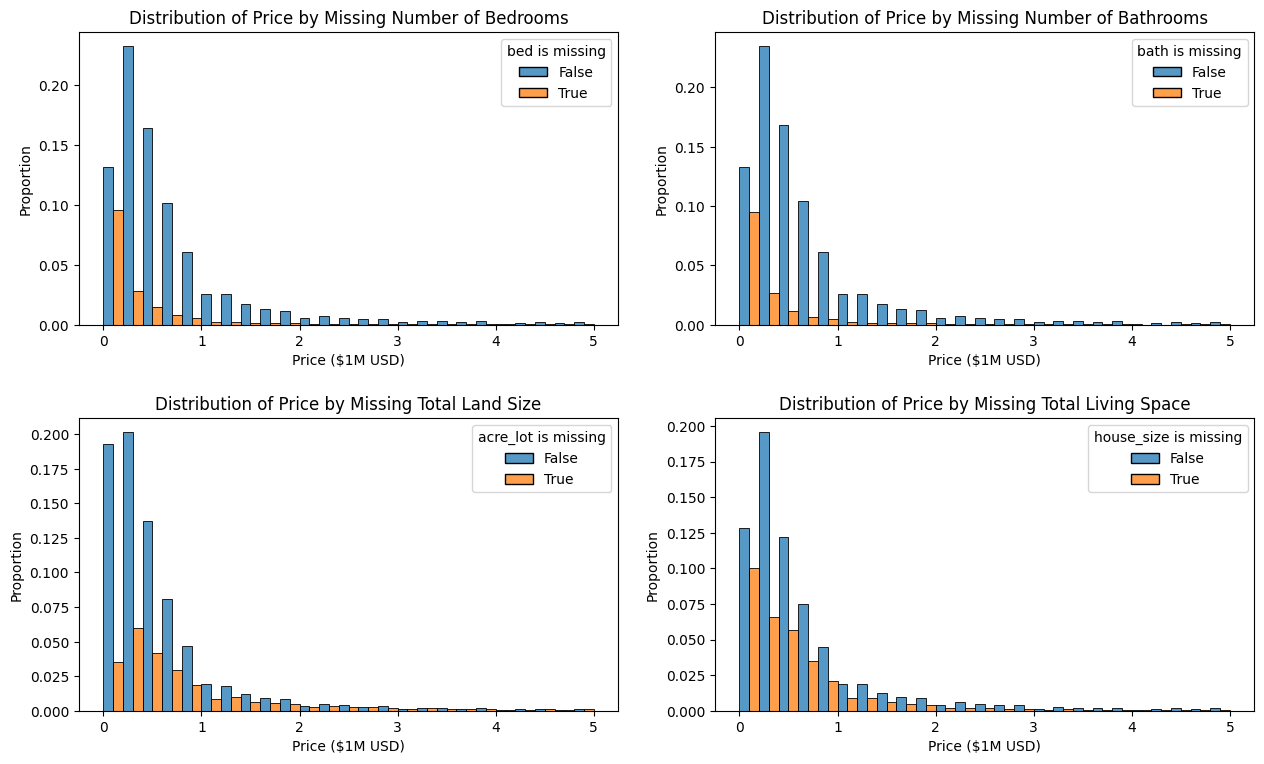

In [ ]:
# change stratification to number of missing values, include kde
# how were outliers chosen?

nrows = 2
ncols = 2

fig = plt.figure(figsize=(13,8))

features_with_missing = ['bed', 'bath', 'acre_lot', 'house_size']

for i, feature in enumerate(features_with_missing):
  df_temp = df.copy()
  df_temp['price'] = df_temp['price'] / 1e6
  df_temp['is_missing'] = df_temp[feature].isna()
  ax = fig.add_subplot(nrows, ncols, i+1)
  sns.histplot(data=df_temp, stat='proportion', common_norm=True, x='price', hue='is_missing', multiple='dodge', binrange=[0, 5], bins=25)
  plt.xlabel("Price ($1M USD)")
  plt.title("Distribution of Price by Missing {}".format(labels[feature]))
  ax.get_legend().set_title("{} is missing".format(feature))
  plt.ticklabel_format(style='plain')

fig.tight_layout(pad=2.0)
plt.show()


Investigate the distribution of numerical features for observations with missing data:

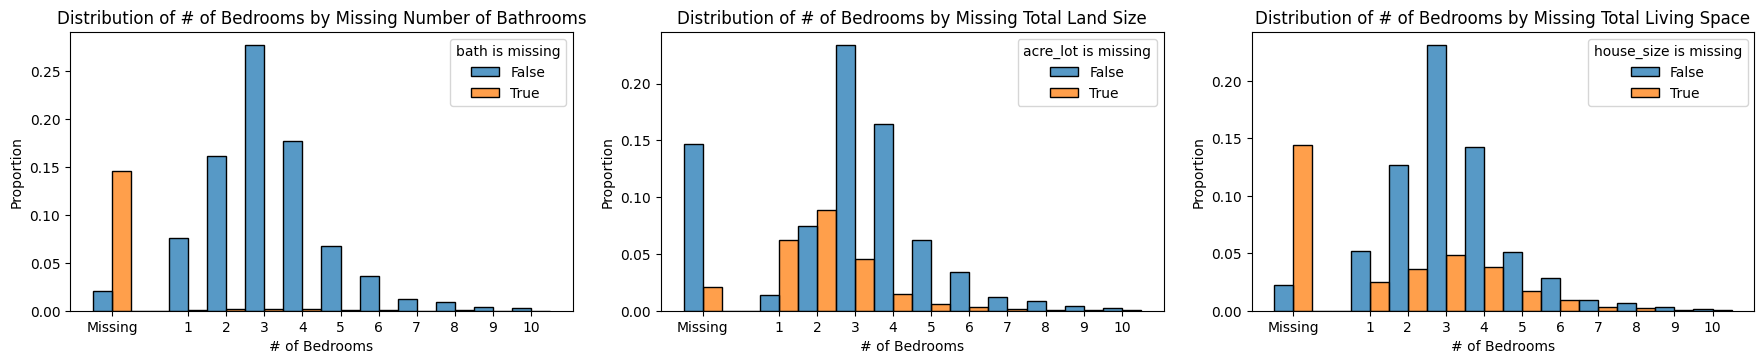

In [ ]:
# change stratification to number of missing values

nrows = 1
ncols = 3

fig = plt.figure(figsize=(18,4))

features_with_missing = ['bath', 'acre_lot', 'house_size']

for i, feature in enumerate(features_with_missing):
  df_temp = df.copy()
  df_temp['is_missing'] = df_temp[feature].isna()
  df_temp['bed'] = df['bed'].fillna(-1)
  ax = fig.add_subplot(nrows, ncols, i+1)
  sns.histplot(data=df_temp, stat='proportion', common_norm=True, x='bed', hue='is_missing', multiple='dodge', binrange=[-1,10], discrete=True)
  plt.xlabel("# of Bedrooms")
  plt.xticks([-1] + [n for n in range(1, 11)], (['Missing'] + [str(n) for n in range(1, 11)]))
  plt.title("Distribution of # of Bedrooms by Missing {}".format(labels[feature]))
  ax.get_legend().set_title("{} is missing".format(feature))

fig.tight_layout(pad=2.0)
plt.show()

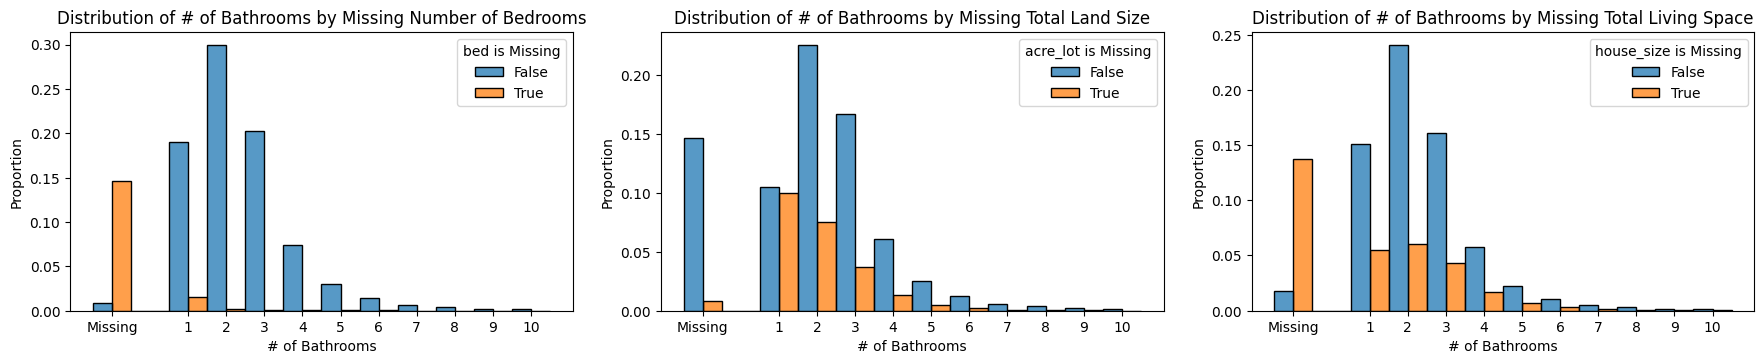

In [ ]:
fig = plt.figure(figsize=(18,4))

features_with_missing = ['bed', 'acre_lot', 'house_size']

for i, feature in enumerate(features_with_missing):
  df_temp = df.copy()
  df_temp['is_missing'] = df_temp[feature].isna()
  df_temp['bath'] = df['bath'].fillna(-1)
  ax = fig.add_subplot(nrows, ncols, i+1)
  sns.histplot(data=df_temp, stat='proportion', common_norm=True, x='bath', hue='is_missing', multiple='dodge', binrange=[-1,10], discrete=True)
  plt.xlabel("# of Bathrooms")
  plt.xticks([-1] + [n for n in range(1, 11)], (['Missing'] + [str(n) for n in range(1, 11)]))
  plt.title("Distribution of # of Bathrooms by Missing {}".format(labels[feature]))
  ax.get_legend().set_title("{} is Missing".format(feature))

fig.tight_layout(pad=2.0)
plt.show()

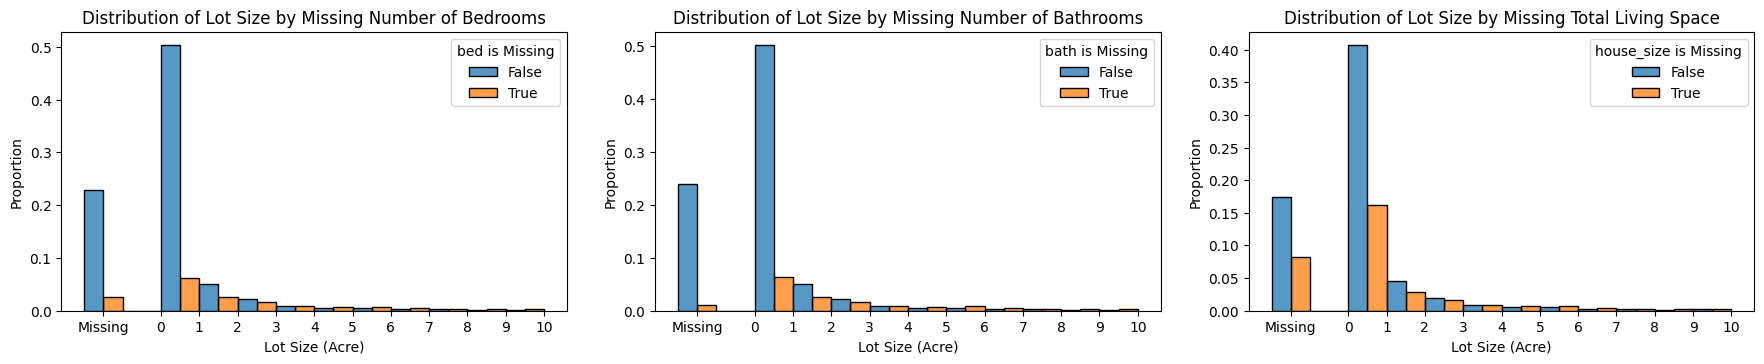

In [ ]:
fig = plt.figure(figsize=(18,4))

features_with_missing = ['bed', 'bath', 'house_size']

for i, feature in enumerate(features_with_missing):
  df_temp = df.copy()
  df_temp['is_missing'] = df_temp[feature].isna()
  df_temp['acre_lot'] = df['acre_lot'].fillna(-2)
  ax = fig.add_subplot(nrows, ncols, i+1)
  sns.histplot(data=df_temp, stat='proportion', common_norm=True, x='acre_lot', hue='is_missing', multiple='dodge', binrange=[-2,10], binwidth=1)
  plt.xlabel("Lot Size (Acre)")
  plt.xticks([-1.5] + [n for n in range(0, 11)], (['Missing'] + [str(n) for n in range(0, 11)]))
  plt.title("Distribution of Lot Size by Missing {}".format(labels[feature]))
  ax.get_legend().set_title("{} is Missing".format(feature))

fig.tight_layout(pad=2.0)
plt.show()

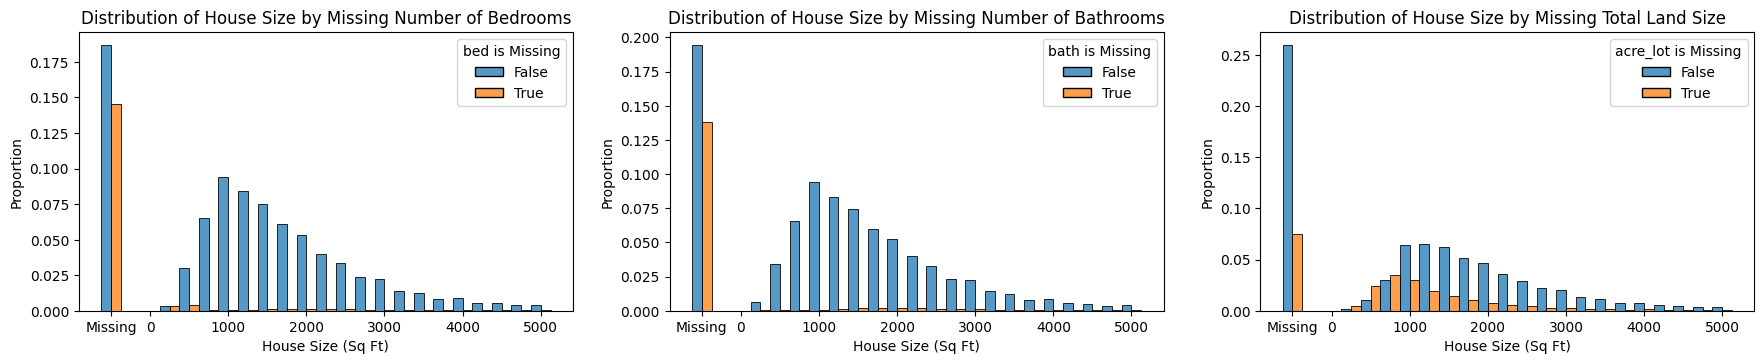

In [ ]:
fig = plt.figure(figsize=(18,4))

features_with_missing = ['bed', 'bath', 'acre_lot']

for i, feature in enumerate(features_with_missing):
  df_temp = df.copy()
  df_temp['is_missing'] = df_temp[feature].isna()
  df_temp['house_size'] = df['house_size'].fillna(-500)
  ax = fig.add_subplot(nrows, ncols, i+1)
  sns.histplot(data=df_temp, stat='proportion', common_norm=True, x='house_size', hue='is_missing', multiple='dodge', binrange=[-500, 5250], binwidth=250)
  plt.xlabel("House Size (Sq Ft)")
  locs = [-500] + [1000 * n for n in range(0, 6)]
  locs = [x + 125 for x in locs]
  plt.xticks(locs, (['Missing'] + [str(1000 * n) for n in range(0, 6)]))
  plt.title("Distribution of House Size by Missing {}".format(labels[feature]))
  ax.get_legend().set_title("{} is Missing".format(feature))

fig.tight_layout(pad=2.0)
plt.show()

##### NOTES

- Variance in target variable `price` is more affected by variance in `bed` and `bath` than variance in `acre_lot` or `house_size`.
- The features `bed` and `bath` are fairly well correlated, even in terms of whether the values are missing.
- The feature `house_size` is slightly correlated with each of `bed` and `bath`.
- A sizable proportions of observations missing `house_size` are also missing `bed` or `bath`. Some of these could be missing at random, others may correspond to emtpy lots (i.e. land with no house).
- Observations with missing values for `acre_lot` have distributions of `bed`, `bath`, and `house_size` that suggest they could correspond to properties like apartments, condos, etc.





## Data pre-processing

First, define dataset for training and testing the model:



In [ ]:
df.dropna(subset=['price'], inplace=True)

price_zero = df[df['price'] == 0].index
df.drop(price_zero, inplace=True)

df.reset_index(inplace=True, drop=True)

df.drop(columns=['city', 'status', 'prev_sold_date'], inplace=True)

Remove observations with missing or zero `price` (this these data are bad for modeling purposes).

Then remove the following features entirely:
- `city` -- since it's determined by `latitude` and `longitude`, which are better variables to use for geographic proximity
- `status` -- because of its extreme imbalance
- `prev_sold_date` --- because it's undefined for almost half the data

### Train/test split

Split dataset into train and test sets:

In [ ]:
df = pd.concat([df.drop('state', axis=1), pd.get_dummies(df['state'])], axis=1)
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = ['bed', 'bath', 'acre_lot', 'house_size', 'latitude', 'longitude']

In [ ]:
X_train.head()

,bed,bath,acre_lot,house_size,latitude,longitude,Connecticut,Delaware,Georgia,Maine,Massachusetts,New Hampshire,New Jersey,New York,Pennsylvania,Rhode Island,Vermont,Virgin Islands,West Virginia,Wyoming
117142,3.0,3.0,0.27,2045.0,41.7035,-73.9117,0,0,0,0,0,0,0,1,0,0,0,0,0,0
87246,2.0,3.0,NaN,NaN,40.7571,-73.9657,0,0,0,0,0,0,0,1,0,0,0,0,0,0
92926,4.0,5.0,NaN,2556.0,40.6451,-73.9450,0,0,0,0,0,0,0,1,0,0,0,0,0,0
47330,1.0,1.0,0.07,480.0,40.5518,-74.1526,0,0,0,0,0,0,0,1,0,0,0,0,0,0
24751,3.0,3.0,0.19,988.0,41.4920,-73.0493,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Remove outliers

In [ ]:
# define outlier thresholds

### Handle missing values

In [ ]:
# define and instantiate imputers

### Pre-processing pipeline

In [ ]:
# define and instantiate pipeline

## Prediction

Define preprocessing steps:

In [279]:
abs_add_one = FunctionTransformer(lambda x: np.abs(x)+1)
transformer = PowerTransformer(method='box-cox')
transformer = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=13)
imputer = KNNImputer(n_neighbors=5)

prep_pipe = Pipeline(
    steps=[
    ('abs_add_one', abs_add_one),
    ('transformer', transformer),
    ('imputer', imputer)
    ]
)

preprocessor = ColumnTransformer([
    ('prep_pipe', prep_pipe, num_features)
])

Define out-of-the-box regression model:

In [238]:
rf_regressor = RandomForestRegressor(random_state=41)

Build pipeline and fit on training data:

In [280]:
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', rf_regressor)
    ]
)

In [281]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('prep_pipe',
                                                  Pipeline(steps=[('abs_add_one',
                                                                   FunctionTransformer(func=<function <lambda> at 0x781695977b50>)),
                                                                  ('transformer',
                                                                   QuantileTransformer(output_distribution='normal',
                                                                                       random_state=13)),
                                                                  ('imputer',
                                                                   KNNImputer())]),
                                                  ['bed', 'bath', 'acre_lot',
                                                   'house_size', 'latitude',
                                                   'longitude'])])),
                ('regressor', RandomForestRegressor(random_state=41))])

Score out-of-the-box model on training data (was 0.628):

In [283]:
pipe.score(X_test, y_test)

-0.23145604457253666

Tune pipeline:



In [149]:
better_params = {
    'regressor__oob_score': True,
    'regressor__max_samples': 0.8
}

pipe.set_params(**better_params)
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('add_one',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7e427cb5b520>)),
                                                                  ('box_cox_transformer',
                                                                   PowerTransformer(method='box-cox')),
                                                                  ('knn_imputer',
                                                                   KNNImputer(n_neighbors=3))]),
                                                  ['bed', 'bath', 'acre_lot',
                                                   'house_size', 'zip_code']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['state'])])),
                ('regressor',
                 RandomForestRegressor(max_samples=0.8, oob_score=True,
                                       random_state=41))])

In [152]:
pipe.score(X_test, y_test)

0.6286897639465385